In [789]:
%matplotlib inline
import numpy as N
import pylab as P
from astropy.table import Table, vstack, Column
from astropy import units as u

In [790]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 71.0, Om0 = 0.26)
c = 299792.458 * u.km/u.s

In [791]:
data = Table.read('mr181920_member_long_groupID_catalog_central_satellites_with_halo_mass.fits', format='fits')

In [792]:
veldisp = Column(name = 'velocity dispersion', data=N.zeros(len(data)), unit=u.km/u.s)
R200 = Column(name='virial radius', data=N.zeros(len(data)), unit=u.Mpc)

In [793]:
for n in (N.unique(data['groupID'])):
    idx = N.where(data['groupID'] == n)
    group_data = data[idx]
    cent_data = group_data[N.where(group_data['central or satellite'] == 1)]
    if len(group_data) > 0 and len(cent_data) == 1:
        vi = c * (group_data['z'] - N.mean(group_data['z']))/(1 + N.mean(group_data['z']))
        vel_disp = N.std(((vi - vi[N.where(group_data['central or satellite'] == 1)])**2)**0.5)
        veldisp[idx] = vel_disp
        R200[idx] = 1.73 * (vel_disp/(1000*u.km/u.s)) * (1/(cosmo.Ode(cent_data['z']) + cosmo.Om0 * (1+cent_data['z'])**3)**0.5) * (1/(cosmo.H0/100)*(u.km/u.s))
    else:
        pass
    if veldisp[idx].any() > 1000:
        print 'WARNING! ACHTUNG! ', n, cent_data['number in cluster'].quantity, cent_data['halo mass'].quantity, group_data['RA', 'Dec', 'z'], vel_disp

KeyboardInterrupt: 

In [ ]:
data.add_columns([veldisp, R200])

In [ ]:
kpca = cosmo.kpc_comoving_per_arcmin(data['z'])
ka = Column(name='kpc per arcmin', data=kpca.value, dtype=float, unit=u.kpc/u.arcmin)
data.add_column(ka)
kd = Column(name='kpc per degree', data = data['kpc per arcmin'].to(u.kpc/u.degree), dtype=float)
data.add_column(kd)
from astropy.coordinates import SkyCoord

In [ ]:
ccr = Column(name='projected cluster centric radius', length=len(data), dtype=float, unit=u.kpc)
for n in (N.unique(data['groupID'])):
    idxs = N.where(N.logical_and(data['groupID']==n, data['central or satellite'] == 0))
    idxc = N.where(N.logical_and(data['groupID']==n, data['central or satellite'] == 1))
    gc = data[idxc]
    gs = data[idxs]
    if len(gc) > 0:
        c1 = SkyCoord(ra=gc['RA'], dec=gc['Dec'], unit=u.degree)
        c2 = SkyCoord(ra=gs['RA'], dec=gs['Dec'], unit=u.degree)
        s = c1.separation(c2)*gs['kpc per degree']
        ccr[idxs] = s
        ccr[idxc] = 0.0
    else:
        pass

In [ ]:
data.add_column(ccr)

In [ ]:
data.write('mr181920_member_long_groupID_catalog_central_satellites_with_halo_mass_projected_clustercentric_radius_vel_disp_virial_radius.fits', format='fits')

In [ ]:
import os
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

P.rc('figure', facecolor='none', edgecolor='none', autolayout=True)
P.rc('path', simplify=True)
P.rc('text', usetex=True)
P.rc('font', family='serif')
P.rc('axes', labelsize='large', facecolor='none', linewidth=0.7, color_cycle = ['k', 'r', 'g', 'b', 'c', 'm', 'y'])
P.rc('xtick', labelsize='medium')
P.rc('ytick', labelsize='medium')
P.rc('lines', markersize=4, linewidth=1, markeredgewidth=0.2)
P.rc('legend', numpoints=1, frameon=False, handletextpad=0.3, scatterpoints=1, handlelength=2, handleheight=0.1)
P.rc('savefig', facecolor='none', edgecolor='none', frameon='False')

params =   {'font.size' : 11,
            'xtick.major.size': 8,
            'ytick.major.size': 8,
            'xtick.minor.size': 3,
            'ytick.minor.size': 3,
            }
P.rcParams.update(params) 

In [ ]:
data = data[N.where(data['number in cluster']>=2)]

In [ ]:
P.figure()
P.hist(data['velocity dispersion'], histtype='step', color='k', normed='True', range=(0,1000))
P.minorticks_on()
P.xlabel(r'$\sigma_{x} [\rm{km} /\rm{s}]$')
P.ylabel(r'$\rm{normalised }$ $\rm{density}$')
P.savefig('velocity_dispersion_distribution.png')

In [ ]:
sat = data[N.where(data['central or satellite']==0)]

In [ ]:
logbins = N.append(N.linspace(0, 1, 6),  N.linspace(2, 15, 8), axis=0)
print logbins

In [ ]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.hist((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'], histtype='step', color='k', bins=logbins, normed=True)
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0, 15)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{normalised }$ $\rm{density}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.savefig('pccr_virial_radius_normalised_distribution.pdf')


In [ ]:
(data['projected cluster centric radius'].to(u.Mpc))/data['virial radius']

In [ ]:
from scipy.stats import binned_statistic as b_s

In [ ]:
bsd = b_s((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], data['t01_smooth_or_features_a02_features_or_disk_debiased'], statistic='mean', bins=logbins, range=(0,15))
bsdstd = b_s((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], data['t01_smooth_or_features_a02_features_or_disk_debiased'], statistic=N.std, bins=logbins, range=(0,15))
y1d = bsd[0] + bsdstd[0]**2
y2d = bsd[0] - bsdstd[0]**2

In [ ]:
bss = b_s((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], data['t01_smooth_or_features_a01_smooth_debiased'], statistic='mean', bins=logbins, range=(0,15))
bssstd = b_s((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], data['t01_smooth_or_features_a01_smooth_debiased'], statistic=N.std, bins=logbins, range=(0,15))
y1s = bss[0] + bssstd[0]**2
y2s = bss[0] - bssstd[0]**2

In [ ]:
bsur = b_s((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], data['MU_MR'], statistic='mean', bins=logbins, range=(0,15))
bsurstd = b_s((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], data['MU_MR'], statistic=N.std, bins=logbins, range=(0,15))
y1ur = bsur[0] + bsurstd[0]**2
y2ur = bsur[0] - bsurstd[0]**2

In [ ]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.scatter(bsur[1][:-1] + N.diff(bsur[1])[0]/2, bsur[0], marker='x', color='k')
ax.fill_between(bsur[1][:-1] + N.diff(bsur[1])[0]/2, y1ur, y2ur, color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$u-r$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.savefig('u_r_trend_with_radius.pdf')

In [ ]:
dat = data[N.where(data['NUV_U']>-1)]

In [ ]:
bsnuv = b_s((dat['projected cluster centric radius'].to(u.Mpc))/dat['virial radius'], N.nan_to_num(dat['NUV_U']), statistic='mean', bins=logbins, range=(0,15))
bsnuvstd = b_s((dat['projected cluster centric radius'].to(u.Mpc))/dat['virial radius'], N.nan_to_num(dat['NUV_U']), statistic=N.var, bins=logbins, range=(0,15))
y1nuv = bsnuv[0] + bsnuvstd[0]**2
y2nuv = bsnuv[0] - bsnuvstd[0]**2

In [ ]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.scatter(bsnuv[1][:-1] + N.diff(bsnuv[1])[0]/2, bsnuv[0], marker='x', color='k')
ax.fill_between(bsnuv[1][:-1] + N.diff(bsnuv[1])[0]/2, y1nuv, y2nuv, color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$NUV-u$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.savefig('nuv_u_trend_with_radius.pdf')

In [ ]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.scatter(bsd[1][:-1] + N.diff(bsd[1])[0]/2, bsd[0], marker='x', color='k')
ax.fill_between(bsd[1][:-1] + N.diff(bsd[1])[0]/2, y1d, y2d, color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$p_{\rm{disc}}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.savefig('p_disc_trend_with_log_radius.pdf')

In [ ]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.scatter(bss[1][:-1] + N.diff(bss[1])[0]/2, bss[0], marker='x', color='k')
ax.fill_between(bss[1][:-1] + N.diff(bss[1])[0]/2, y1s, y2s, color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$p_{\rm{smooth}}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.savefig('p_smooth_trend_with_log_radius.pdf')

In [ ]:
bsb = b_s((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'], sat['t03_bar_a06_bar_debiased'], statistic='mean', bins=logbins, range=(0,15))
bsbstd = b_s((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'], sat['t03_bar_a06_bar_debiased'], statistic=N.std, bins=logbins, range=(0,15))
y1b = bsb[0] + bsbstd[0]**2
y2b = bsb[0] - bsbstd[0]**2

In [ ]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.scatter(bsb[1][:-1] + N.diff(bsb[1])[0]/2, bsb[0], marker='x', color='k')
ax.fill_between(bsb[1][:-1] + N.diff(bsb[1])[0]/2, y1b, y2b, color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$p_{\rm{bar}}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.savefig('p_bar_trend_with_log_radius.pdf')

In [ ]:
bso = b_s((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'], sat['t06_odd_a14_yes_debiased'], statistic='median', bins=logbins, range=(0,15))

In [ ]:
bsostd = b_s((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'], sat['t06_odd_a14_yes_debiased'], statistic=N.std, bins=logbins, range=(0,15))

In [ ]:
y1o = bso[0] + bsostd[0]**2
y2o = bso[0] - bsostd[0]**2

In [ ]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, bso[0], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1o, y2o, color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$p_{\rm{odd}}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.savefig('p_odd_trend_with_log_radius.pdf')

In [ ]:
idxrs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_d = [len(data['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k][data['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k]>=0.7])/float(len(data[idxrs==k])+1) for k in range(len(logbins))]
frac_s = [len(data['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k][data['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k]>=0.7])/float(len(data[idxrs==k])+1) for k in range(len(logbins))]
num_d = [float(len(data['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k][data['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k]>=0.7])) for k in range(len(logbins))]
num_s = [float(len(data['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k][data['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k]>=0.7])) for k in range(len(logbins))]
num_t = [float(len(data[idxrs==k])+1) for k in range(len(logbins))]
error_frac_d = N.nan_to_num(frac_d*N.sqrt((1/N.array(num_d))+(1/N.array(num_t))))
error_frac_s = N.nan_to_num(frac_s*N.sqrt((1/N.array(num_s))+(1/N.array(num_t))))



In [ ]:
len(frac_d)

In [ ]:
y1ed = frac_d + error_frac_d
y2ed = frac_d - error_frac_d
y1es = frac_s + error_frac_s
y2es = frac_s - error_frac_s
print N.shape(y1ed)
print N.shape(bso[1][:-1] + N.diff(bso[1])[0]/2)
print error_frac_d

In [ ]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_d[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1ed[1:], y2ed[1:], color='k', alpha=0.15, edgecolor='None')
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_s[1:], marker='o', color='r')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1es[1:], y2es[1:], color='r', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{fraction}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.tight_layout()
P.savefig('disc_and_smooth_fraction_trend_with_log_radius.pdf')

In [ ]:
idxrs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_odd = [len(data[data['t06_odd_a14_yes_debiased'][idxrs==k]>=0.4])/float(len(data[idxrs==k])+1) for k in range(len(logbins))]
num_odd = [float(len(data[data['t06_odd_a14_yes_debiased'][idxrs==k]>=0.4])) for k in range(len(logbins))]
num_t = [float(len(data[idxrs==k])+1) for k in range(len(logbins))]
error_frac_odd = N.nan_to_num(frac_odd*N.sqrt((1/N.array(num_odd))+(1/N.array(num_t))))
y1eodd = frac_odd + error_frac_odd
y2eodd = frac_odd - error_frac_odd

In [ ]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_odd[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1eodd[1:], y2eodd[1:], color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{fraction}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.tight_layout()
P.savefig('odd_fraction_trend_with_log_radius.pdf')

In [ ]:
idxrs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_m = [len(data[data['t08_odd_feature_a24_merger_debiased'][idxrs==k]>=0.3])/float(len(data[idxrs==k])+1) for k in range(len(logbins))]
num_m = [float(len(data[data['t08_odd_feature_a24_merger_debiased'][idxrs==k]>=0.3])) for k in range(len(logbins))]
num_t = [float(len(data[idxrs==k])+1) for k in range(len(logbins))]
error_frac_m = N.nan_to_num(frac_m*N.sqrt((1/N.array(num_m))+(1/N.array(num_t))))
y1em = frac_m + error_frac_m
y2em = frac_m - error_frac_m

In [ ]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_m[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1em[1:], y2em[1:], color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
#ax.set_ylim(0, 0.05)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{fraction}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.tight_layout()
P.savefig('merger_fraction_trend_with_log_radius.pdf')

In [ ]:
idxrs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_d = [len(data[data['t08_odd_feature_a21_disturbed_debiased'][idxrs==k]>=0.4])/float(len(data[idxrs==k])+1) for k in range(len(logbins))]
num_d = [float(len(data[data['t08_odd_feature_a21_disturbed_debiased'][idxrs==k]>=0.4])) for k in range(len(logbins))]
num_t = [float(len(data[idxrs==k])+1) for k in range(len(logbins))]
error_frac_d = N.nan_to_num(frac_d*N.sqrt((1/N.array(num_d))+(1/N.array(num_t))))
y1ed = frac_d + error_frac_d
y2ed = frac_d - error_frac_d

In [ ]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_d[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1ed[1:], y2ed[1:], color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
#ax.set_ylim(0, 0.05)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{fraction}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.tight_layout()
P.savefig('disturbed_fraction_trend_with_log_radius.pdf')

In [ ]:
discs = data[N.where(N.logical_and(data['t01_smooth_or_features_a02_features_or_disk_debiased'] > 0.430, data['t02_edgeon_a05_no_debiased']>0.715, data['t02_edgeon_a05_no_count']>=20))]

In [ ]:
idxrs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
idxds = N.digitize((discs['projected cluster centric radius'].to(u.Mpc))/discs['virial radius'], logbins)
frac_b = [len(discs[discs['t03_bar_a06_bar_debiased'][idxds==k]>=0.6])/float(len(discs[idxds==k])+1) for k in range(len(logbins))]
num_b = [float(len(discs[data['t03_bar_a06_bar_debiased'][idxds==k]>=0.6])) for k in range(len(logbins))]
num_t = [float(len(discs[idxds==k])+1) for k in range(len(logbins))]
error_frac_b = N.nan_to_num(frac_b*N.sqrt((1/N.array(num_b))+(1/N.array(num_t))))
y1eb = frac_b + error_frac_b
y2eb = frac_b - error_frac_b

In [ ]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_b[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1eb[1:], y2eb[1:], color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
#ax.set_ylim(0, 0.05)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{fraction}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.tight_layout()
P.savefig('bar_fraction_over_disc_trend_with_log_radius.pdf')

In [ ]:
red = data[N.where(data['MU_MR']> data['upper_GV'])]
green = data[N.where(N.logical_and(data['MU_MR'] < data['upper_GV'], data['MU_MR'] > data['lower_GV']))]
blue = data[N.where(data['MU_MR']< data['lower_GV'])]

In [ ]:
print len(red), len(green), len(blue)

In [896]:
idxrs = N.digitize((red['projected cluster centric radius'].to(u.Mpc))/red['virial radius'], logbins)
idxs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_dr = [len(red['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k][red['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k]>=0.7])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
frac_sr = [len(red['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k][red['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k]>=0.7])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
num_dr = [float(len(red['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k][red['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k]>=0.7])) for k in range(len(logbins))]
num_sr = [float(len(red['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k][red['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k]>=0.7])) for k in range(len(logbins))]
num_tr = [float(len(data[idxs==k])+1) for k in range(len(logbins))]
error_frac_dr = N.nan_to_num(frac_dr*N.sqrt((1/N.array(num_dr))+(1/N.array(num_tr))))
error_frac_sr = N.nan_to_num(frac_sr*N.sqrt((1/N.array(num_sr))+(1/N.array(num_tr))))
y1edr = frac_dr + error_frac_dr
y2edr = frac_dr - error_frac_dr
y1esr = frac_sr + error_frac_sr
y2esr = frac_sr - error_frac_sr

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in multiply


In [897]:
idxrs = N.digitize((green['projected cluster centric radius'].to(u.Mpc))/green['virial radius'], logbins)
idxs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_dg = [len(green['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k][green['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k]>=0.7])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
frac_sg = [len(green['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k][green['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k]>=0.7])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
num_dg = [float(len(green['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k][green['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k]>=0.7])) for k in range(len(logbins))]
num_sg = [float(len(green['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k][green['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k]>=0.7])) for k in range(len(logbins))]
num_tg = [float(len(data[idxs==k])+1) for k in range(len(logbins))]
error_frac_dg = N.nan_to_num(frac_dg*N.sqrt((1/N.array(num_dg))+(1/N.array(num_tg))))
error_frac_sg = N.nan_to_num(frac_sg*N.sqrt((1/N.array(num_sg))+(1/N.array(num_tg))))
y1edg = frac_dg + error_frac_dg
y2edg = frac_dg - error_frac_dg
y1esg = frac_sg + error_frac_sg
y2esg = frac_sg - error_frac_sg

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in multiply


In [898]:
idxrs = N.digitize((blue['projected cluster centric radius'].to(u.Mpc))/blue['virial radius'], logbins)
idxs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_db = [len(blue['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k][blue['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k]>=0.7])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
frac_sb = [len(blue['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k][blue['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k]>=0.7])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
num_db = [float(len(blue['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k][blue['t01_smooth_or_features_a02_features_or_disk_debiased'][idxrs==k]>=0.7])) for k in range(len(logbins))]
num_sb = [float(len(blue['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k][blue['t01_smooth_or_features_a01_smooth_debiased'][idxrs==k]>=0.7])) for k in range(len(logbins))]
num_tb = [float(len(data[idxs==k])+1) for k in range(len(logbins))]
error_frac_db = N.nan_to_num(frac_db*N.sqrt((1/N.array(num_db))+(1/N.array(num_tb))))
error_frac_sb = N.nan_to_num(frac_sb*N.sqrt((1/N.array(num_sb))+(1/N.array(num_tb))))
y1edb = frac_db + error_frac_db
y2edb = frac_db - error_frac_db
y1esb = frac_sb + error_frac_sb
y2esb = frac_sb - error_frac_sb

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in multiply


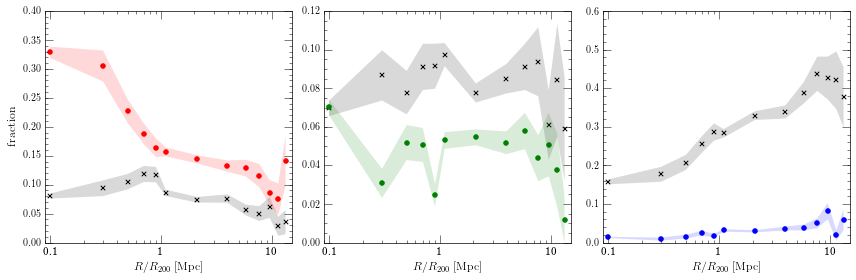

In [899]:
P.figure(figsize=(12,4))
ax = P.subplot(131)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_dr[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1edr[1:], y2edr[1:], color='k', alpha=0.15, edgecolor='None')
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_sr[1:], marker='o', color='r')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1esr[1:], y2esr[1:], color='r', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$ $[\rm{Mpc}]$')
ax.set_ylabel(r'$\rm{fraction}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax = P.subplot(132)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_dg[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1edg[1:], y2edg[1:], color='k', alpha=0.15, edgecolor='None')
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_sg[1:], marker='o', color='g')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1esg[1:], y2esg[1:], color='g', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$ $[\rm{Mpc}]$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax = P.subplot(133)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_db[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1edb[1:], y2edb[1:], color='k', alpha=0.15, edgecolor='None')
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_sb[1:], marker='o', color='b')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1esb[1:], y2esb[1:], color='b', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$ $[\rm{Mpc}]$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.tight_layout()
P.savefig('RGB_disc_and_smooth_fraction_over_data_trend_with_log_radius.pdf')

In [800]:
data = Table.read('mr181920_member_long_groupID_catalog_central_satellites_with_halo_mass_projected_clustercentric_radius_vel_disp_virial_radius.fits', format='fits')

In [801]:
data = data[N.where(data['number in cluster']>=2)]

In [802]:
red = data[N.where(data['MU_MR']> data['upper_GV'])]
green = data[N.where(N.logical_and(data['MU_MR'] < data['upper_GV'], data['MU_MR'] > data['lower_GV']))]
blue = data[N.where(data['MU_MR']< data['lower_GV'])]

In [900]:
idxrs = N.digitize((red['projected cluster centric radius'].to(u.Mpc))/red['virial radius'], logbins)
idxs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_oddr = [len(red[red['t06_odd_a14_yes_debiased'][idxrs==k]>=0.4])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
num_oddr = [float(len(red[red['t06_odd_a14_yes_debiased'][idxrs==k]>=0.4])) for k in range(len(logbins))]
num_tr = [float(len(data[idxs==k])+1) for k in range(len(logbins))]
error_frac_oddr = N.nan_to_num(frac_oddr*N.sqrt((1/N.array(num_oddr))+(1/N.array(num_tr))))
y1eoddr = frac_oddr + error_frac_oddr
y2eoddr = frac_oddr - error_frac_oddr

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply


In [901]:
idxrs = N.digitize((green['projected cluster centric radius'].to(u.Mpc))/green['virial radius'], logbins)
idxs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_oddg = [len(green[green['t06_odd_a14_yes_debiased'][idxrs==k]>=0.4])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
num_oddg = [float(len(green[green['t06_odd_a14_yes_debiased'][idxrs==k]>=0.4])) for k in range(len(logbins))]
num_tg = [float(len(data[idxs==k])+1) for k in range(len(logbins))]
error_frac_oddg = N.nan_to_num(frac_oddg*N.sqrt((1/N.array(num_oddg))+(1/N.array(num_tg))))
y1eoddg = frac_oddg + error_frac_oddg
y2eoddg = frac_oddg - error_frac_oddg

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply


In [902]:
idxrs = N.digitize((blue['projected cluster centric radius'].to(u.Mpc))/blue['virial radius'], logbins)
idxs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_oddb = [len(blue[blue['t06_odd_a14_yes_debiased'][idxrs==k]>=0.4])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
num_oddb = [float(len(blue[blue['t06_odd_a14_yes_debiased'][idxrs==k]>=0.4])) for k in range(len(logbins))]
num_tb = [float(len(data[idxs==k])+1) for k in range(len(logbins))]
error_frac_oddb = N.nan_to_num(frac_oddb*N.sqrt((1/N.array(num_oddb))+(1/N.array(num_tb))))
y1eoddb = frac_oddb+ error_frac_oddb
y2eoddb = frac_oddb - error_frac_oddb

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply


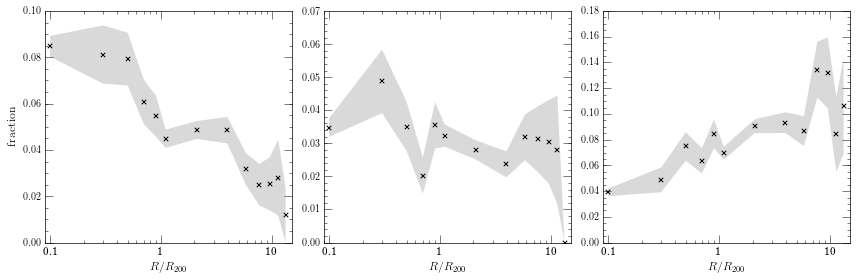

In [903]:
P.figure(figsize=(12,4))
ax = P.subplot(131)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_oddr[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1eoddr[1:], y2eoddr[1:], color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{fraction}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax = P.subplot(132)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_oddg[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1eoddg[1:], y2eoddg[1:], color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax = P.subplot(133)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_oddb[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1eoddb[1:], y2eoddb[1:], color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.tight_layout()
P.savefig('RGB_odd_fraction_over_data_trend_with_log_radius.pdf')

In [ ]:
N.percentile(data['halo mass'], [33, 66])

In [ ]:
high = data[N.where(data['halo mass']> 13)]
med = data[N.where(N.logical_and(data['halo mass'] < 13, data['halo mass'] > 12.3))]
low = data[N.where(data['halo mass']< 12.3)]

In [ ]:
print len(high), len(med), len(low)

In [ ]:
N.percentile((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'], [3, 50, 84])

In [ ]:
len(sat[N.where((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'] < 1)])/float(len(sat))*100

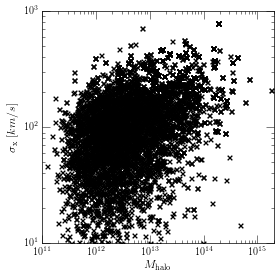

In [824]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.scatter(10**data['halo mass'], data['velocity dispersion'], color='k', marker='x')
ax.set_xlabel(r'$M_{\rm{halo}}$')
ax.set_ylabel(r'$\sigma_{\rm{x}}$ $[km/s]$')
ax.set_xlim(1E11,2E15)
ax.set_ylim(10,1000)
ax.minorticks_on()
ax.set_xscale('log')
ax.set_yscale('log')
P.tight_layout()
P.savefig('halo_mass_versus_sigma.pdf')

In [833]:
sat = data[N.where(data['central or satellite']==0)]

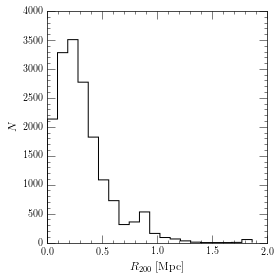

In [850]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.hist(data['virial radius'], color='k', histtype='step', bins=20)
ax.set_xlabel(r'$R_{200}$ $[\rm{Mpc}]$')
ax.set_ylabel(r'$N$')
ax.minorticks_on()
P.tight_layout()
P.savefig('virial_radius_distribution.pdf')

In [851]:
print len(red), len(green), len(blue)

7107 3476 6332


In [852]:
rsat = red[N.where(red['central or satellite']==0)]
gsat = green[N.where(green['central or satellite']==0)]
bsat = blue[N.where(blue['central or satellite']==0)]

In [853]:
print len(rsat), len(gsat), len(bsat)

4641 2530 5414


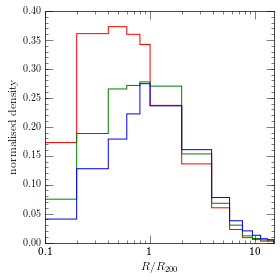

In [854]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.hist((rsat['projected cluster centric radius'].to(u.Mpc))/rsat['virial radius'], histtype='step', color='r', bins=logbins, normed=True)
ax.hist((gsat['projected cluster centric radius'].to(u.Mpc))/gsat['virial radius'], histtype='step', color='g', bins=logbins, normed=True)
ax.hist((bsat['projected cluster centric radius'].to(u.Mpc))/bsat['virial radius'], histtype='step', color='b', bins=logbins, normed=True)
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0, 15)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{normalised }$ $\rm{density}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.savefig('RGB_pccr_virial_radius_normalised_distribution.pdf')


In [855]:
rcl = red[N.where(red['central or satellite']==1)]
gcl = green[N.where(green['central or satellite']==1)]
bcl = blue[N.where(blue['central or satellite']==1)]

In [862]:
print len(rcl), len(gcl), len(bcl)

2466 946 918


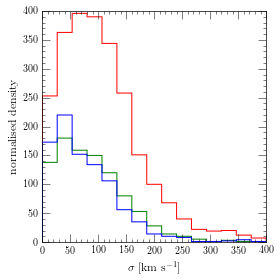

In [871]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.hist((rcl['velocity dispersion']), histtype='step', color='r', bins=15, range=(0,400))
ax.hist((gcl['velocity dispersion']), histtype='step', color='g', bins=15, range=(0,400))
ax.hist((bcl['velocity dispersion']), histtype='step', color='b', bins=15, range=(0,400))
ax.minorticks_on()
ax.set_xlabel(r'$\sigma$ $[\rm{km}$ $\rm{s}^{-1}]$')
ax.set_ylabel(r'$\rm{normalised }$ $\rm{density}$')
P.savefig('RGB_vel_disp_normalised_distribution.pdf')


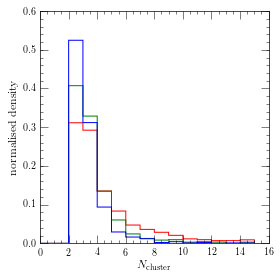

In [872]:
P.figure(figsize=(4,4))
ax = P.subplot(111)
ax.hist((rcl['number in cluster']), histtype='step', color='r', bins=15, range=(0, 15), normed=True)
ax.hist((gcl['number in cluster']), histtype='step', color='g', bins=15, range=(0, 15), normed=True)
ax.hist((bcl['number in cluster']), histtype='step', color='b', bins=15, range=(0, 15), normed=True)
ax.minorticks_on()
ax.set_xlabel(r'$N_{\rm{cluster}}$')
ax.set_ylabel(r'$\rm{normalised }$ $\rm{density}$')
P.savefig('RGB_N_cluster_normalised_distribution.pdf')


In [1007]:
idxrs = N.digitize((red['projected cluster centric radius'].to(u.Mpc))/red['virial radius'], logbins)
idxs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_mr = [len(red[red['t08_odd_feature_a24_merger_debiased'][idxrs==k]>=0.4])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
num_mr = [float(len(red[red['t08_odd_feature_a24_merger_debiased'][idxrs==k]>=0.4])) for k in range(len(logbins))]
num_tr = [float(len(data[idxs==k])+1) for k in range(len(logbins))]
error_frac_mr = N.nan_to_num(frac_mr*N.sqrt((1/N.array(num_mr))+(1/N.array(num_tr))))
y1emr = frac_mr + error_frac_mr
y2emr = frac_mr - error_frac_mr
l_frac_mr = map(lambda x,y: str(int(x))+'/'+str(int(y)), num_mr,num_tr) 

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply


In [1008]:
idxrs = N.digitize((green['projected cluster centric radius'].to(u.Mpc))/green['virial radius'], logbins)
idxs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_mg = [len(green[green['t08_odd_feature_a24_merger_debiased'][idxrs==k]>=0.4])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
num_mg = [float(len(green[green['t08_odd_feature_a24_merger_debiased'][idxrs==k]>=0.4])) for k in range(len(logbins))]
num_tg = [float(len(data[idxs==k])+1) for k in range(len(logbins))]
error_frac_mg = N.nan_to_num(frac_mg*N.sqrt((1/N.array(num_mg))+(1/N.array(num_tg))))
y1emg = frac_mg + error_frac_mg
y2emg = frac_mg - error_frac_mg
l_frac_mg = map(lambda x,y: str(int(x))+'/'+str(int(y)), num_mg,num_tg) 


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply


In [1009]:
idxrs = N.digitize((blue['projected cluster centric radius'].to(u.Mpc))/blue['virial radius'], logbins)
idxs = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
frac_mb = [len(blue[blue['t08_odd_feature_a24_merger_debiased'][idxrs==k]>=0.4])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
num_mb = [float(len(blue[blue['t08_odd_feature_a24_merger_debiased'][idxrs==k]>=0.4])) for k in range(len(logbins))]
num_tb = [float(len(data[idxs==k])+1) for k in range(len(logbins))]
error_frac_mb = N.nan_to_num(frac_mb*N.sqrt((1/N.array(num_mb))+(1/N.array(num_tb))))
y1emb = frac_mb + error_frac_mb
y2emb = frac_mb - error_frac_mb
l_frac_mb = map(lambda x,y: str(int(x))+'/'+str(int(y)), num_mb,num_tb) 

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply


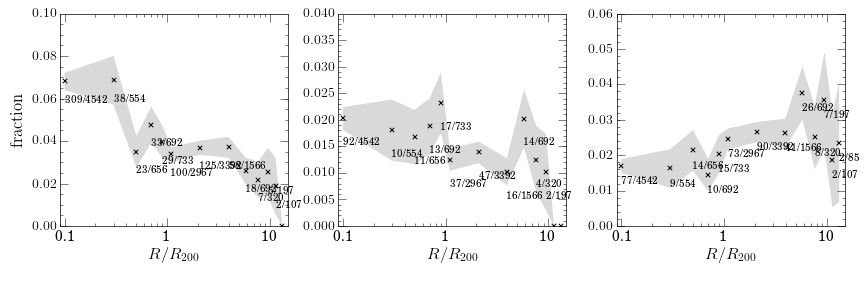

In [1010]:
P.figure(figsize=(12,4))
ax = P.subplot(131)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_mr[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1emr[1:], y2emr[1:], color='k', alpha=0.15, edgecolor='None')
for i, txt in enumerate(l_frac_mr[1:]):
    ax.annotate(txt, ((bso[1][:-1] + N.diff(bso[1])[0]/2)[i],frac_mr[1:][i]-0.01), fontsize=10)
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{fraction}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax = P.subplot(132)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_mg[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1emg[1:], y2emg[1:], color='k', alpha=0.15, edgecolor='None')
for i, txt in enumerate(l_frac_mg[1:]):
    ax.annotate(txt, ((bso[1][:-1] + N.diff(bso[1])[0]/2)[i],frac_mg[1:][i]-0.005), fontsize=10)
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax = P.subplot(133)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_mb[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1emb[1:], y2emb[1:], color='k', alpha=0.15, edgecolor='None')
for i, txt in enumerate(l_frac_mb[1:]):
    ax.annotate(txt, ((bso[1][:-1] + N.diff(bso[1])[0]/2)[i],frac_mb[1:][i]-0.005), fontsize=10)
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.tight_layout()
P.savefig('RGB_merger_fraction_over_data_trend_with_log_radius.pdf')

In [917]:
discs = data[N.where(N.logical_and(data['t01_smooth_or_features_a02_features_or_disk_debiased'] > 0.430, data['t02_edgeon_a05_no_debiased']>0.715, data['t02_edgeon_a05_no_count']>=20))]
redd = discs[N.where(discs['MU_MR']> discs['upper_GV'])]
greend = discs[N.where(N.logical_and(discs['MU_MR'] < discs['upper_GV'], discs['MU_MR'] > discs['lower_GV']))]
blued = discs[N.where(discs['MU_MR']< discs['lower_GV'])]

In [1002]:
idxrs = N.digitize((redd['projected cluster centric radius'].to(u.Mpc))/redd['virial radius'], logbins)
idxs = N.digitize((discs['projected cluster centric radius'].to(u.Mpc))/discs['virial radius'], logbins)
frac_mr = [len(redd[redd['t03_bar_a06_bar_debiased'][idxrs==k]>=0.4])/float(len(discs[idxs==k])+1) for k in range(len(logbins))]
num_mr = [float(len(redd[redd['t03_bar_a06_bar_debiased'][idxrs==k]>=0.4])) for k in range(len(logbins))]
num_tr = [float(len(discs[idxs==k])+1) for k in range(len(logbins))]
error_frac_mr = N.nan_to_num(frac_mr*N.sqrt((1/N.array(num_mr))+(1/N.array(num_tr))))
y1emr = frac_mr + error_frac_mr
y2emr = frac_mr - error_frac_mr
l_frac_mr = map(lambda x,y: str(int(x))+'/'+str(int(y)), num_mr,num_tr) 


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply


In [1003]:
idxrs = N.digitize((greend['projected cluster centric radius'].to(u.Mpc))/greend['virial radius'], logbins)
idxs = N.digitize((discs['projected cluster centric radius'].to(u.Mpc))/discs['virial radius'], logbins)
frac_mg = [len(greend[greend['t03_bar_a06_bar_debiased'][idxrs==k]>=0.4])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
num_mg = [float(len(greend[greend['t03_bar_a06_bar_debiased'][idxrs==k]>=0.4])) for k in range(len(logbins))]
num_tg = [float(len(discs[idxs==k])+1) for k in range(len(logbins))]
error_frac_mg = N.nan_to_num(frac_mg*N.sqrt((1/N.array(num_mg))+(1/N.array(num_tg))))
y1emg = frac_mg + error_frac_mg
y2emg = frac_mg - error_frac_mg
l_frac_mg = map(lambda x,y: str(int(x))+'/'+str(int(y)), num_mg,num_tg) 


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply


In [1004]:
idxrs = N.digitize((blued['projected cluster centric radius'].to(u.Mpc))/blued['virial radius'], logbins)
idxs = N.digitize((discs['projected cluster centric radius'].to(u.Mpc))/discs['virial radius'], logbins)
frac_mb = [len(blued[blued['t03_bar_a06_bar_debiased'][idxrs==k]>=0.4])/float(len(data[idxs==k])+1) for k in range(len(logbins))]
num_mb = [float(len(blued[blued['t03_bar_a06_bar_debiased'][idxrs==k]>=0.4])) for k in range(len(logbins))]
num_tb = [float(len(discs[idxs==k])+1) for k in range(len(logbins))]
error_frac_mb = N.nan_to_num(frac_mb*N.sqrt((1/N.array(num_mb))+(1/N.array(num_tb))))
y1emb = frac_mb + error_frac_mb
y2emb = frac_mb - error_frac_mb
l_frac_mb = map(lambda x,y: str(int(x))+'/'+str(int(y)), num_mb,num_tb) 


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply


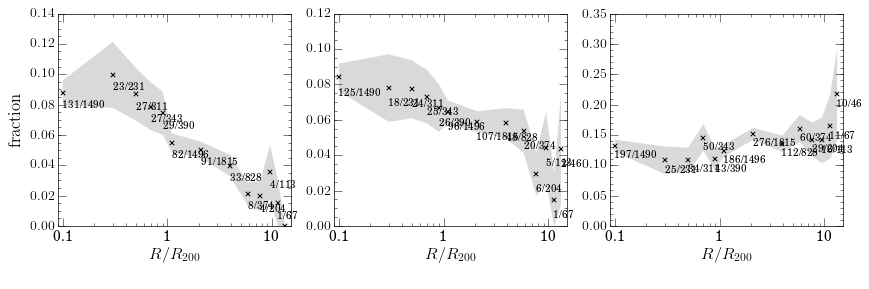

In [1005]:
P.figure(figsize=(12,4))
ax = P.subplot(131)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_mr[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1emr[1:], y2emr[1:], color='k', alpha=0.15, edgecolor='None')
for i, txt in enumerate(l_frac_mr[1:]):
    ax.annotate(txt, ((bso[1][:-1] + N.diff(bso[1])[0]/2)[i],frac_mr[1:][i]-0.01), fontsize=10)
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{fraction}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax = P.subplot(132)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_mg[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1emg[1:], y2emg[1:], color='k', alpha=0.15, edgecolor='None')
for i, txt in enumerate(l_frac_mg[1:]):
    ax.annotate(txt, ((bso[1][:-1] + N.diff(bso[1])[0]/2)[i],frac_mg[1:][i]-0.01), fontsize=10)
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax = P.subplot(133)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_mb[1:], marker='x', color='k')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1emb[1:], y2emb[1:], color='k', alpha=0.15, edgecolor='None')
for i, txt in enumerate(l_frac_mb[1:]):
    ax.annotate(txt, ((bso[1][:-1] + N.diff(bso[1])[0]/2)[i],frac_mb[1:][i]-0.02), fontsize=10)
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
P.tight_layout()
P.savefig('RGB_bar_fraction_over_discs_trend_with_log_radius.pdf')

(array([  543.,  2309.,  2278.,  2675.,  1729.,  2299.,  1548.,  1457.,
         1273.,   804.]),
 array([ 0.01513,  0.02339,  0.03164,  0.0399 ,  0.04815,  0.05641,
         0.06466,  0.07292,  0.08117,  0.08943,  0.09768]),
 <a list of 1 Patch objects>)

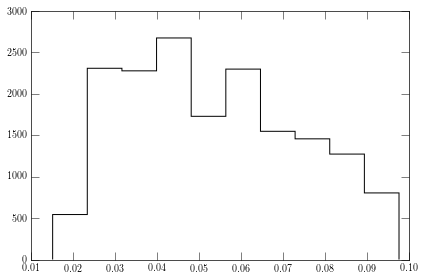

In [922]:
P.figure()
P.hist(data['z'], histtype='step', color='k')

In [923]:
cosmo.age(N.max(data['z']))

<Quantity 12.54827099703802 Gyr>

In [924]:
cosmo.age(N.min(data['z']))

<Quantity 13.600914123744644 Gyr>

In [925]:
N.mean(data['upper_GV'])

2.3373805915939214

In [926]:
N.mean(data['lower_GV'])

2.0813805915939212

In [982]:
lim = 0.5
idxs = N.digitize((discs['projected cluster centric radius'].to(u.Mpc))/discs['virial radius'], logbins)
num_t = [float(len(data[idxs==k])+1) for k in range(len(logbins))]
frac_nb = [len(discs[discs['t05_bulge_prominence_a10_no_bulge_debiased'][idxs==k]>=lim])/float(len(discs[idxs==k])+1) for k in range(len(logbins))]
num_nb = [float(len(discs[discs['t05_bulge_prominence_a10_no_bulge_debiased'][idxs==k]>=lim])) for k in range(len(logbins))]
error_frac_nb = N.nan_to_num(frac_nb*N.sqrt((1/N.array(num_nb))+(1/N.array(num_t))))
y1enb = frac_nb + error_frac_nb
y2enb = frac_nb - error_frac_nb
frac_jnb = [len(discs[discs['t05_bulge_prominence_a11_just_noticeable_debiased'][idxs==k]>=lim])/float(len(discs[idxs==k])+1) for k in range(len(logbins))]
num_jnb = [float(len(discs[discs['t05_bulge_prominence_a11_just_noticeable_debiased'][idxs==k]>=lim])) for k in range(len(logbins))]
error_frac_jnb = N.nan_to_num(frac_jnb*N.sqrt((1/N.array(num_jnb))+(1/N.array(num_t))))
y1ejnb = frac_jnb + error_frac_jnb
y2ejnb = frac_jnb - error_frac_jnb
frac_ob = [len(discs[discs['t05_bulge_prominence_a12_obvious_debiased'][idxs==k]>=lim])/float(len(discs[idxs==k])+1) for k in range(len(logbins))]
num_ob = [float(len(discs[discs['t05_bulge_prominence_a12_obvious_debiased'][idxs==k]>=lim])) for k in range(len(logbins))]
error_frac_ob = N.nan_to_num(frac_ob*N.sqrt((1/N.array(num_ob))+(1/N.array(num_t))))
y1eob = frac_ob + error_frac_ob
y2eob = frac_ob - error_frac_ob
frac_db = [len(discs[discs['t05_bulge_prominence_a13_dominant_debiased'][idxs==k]>=lim])/float(len(discs[idxs==k])+1) for k in range(len(logbins))]
num_db = [float(len(discs[discs['t05_bulge_prominence_a13_dominant_debiased'][idxs==k]>=lim])) for k in range(len(logbins))]
error_frac_db = N.nan_to_num(frac_db*N.sqrt((1/N.array(num_db))+(1/N.array(num_t))))
y1edb = frac_db + error_frac_db
y2edb = frac_db - error_frac_db
frac_minb = [(len(discs[discs['t05_bulge_prominence_a10_no_bulge_debiased'][idxs==k]>=lim])+len(discs[discs['t05_bulge_prominence_a11_just_noticeable_debiased'][idxs==k]>=lim]))/float(len(discs[idxs==k])+1) for k in range(len(logbins))]
num_minb = [float(len(discs[discs['t05_bulge_prominence_a10_no_bulge_debiased'][idxs==k]>=lim])+len(discs[discs['t05_bulge_prominence_a11_just_noticeable_debiased'][idxs==k]>=lim])) for k in range(len(logbins))]
error_frac_minb = N.nan_to_num(frac_minb*N.sqrt((1/N.array(num_minb))+(1/N.array(num_t))))
l_frac_minb = map(lambda x,y: str(int(x))+'/'+str(int(y)), num_minb,num_t) 
y1eminb = frac_minb + error_frac_minb
y2eminb = frac_minb - error_frac_minb
frac_maxb = [(len(discs[discs['t05_bulge_prominence_a12_obvious_debiased'][idxs==k]>=lim])+len(discs[discs['t05_bulge_prominence_a13_dominant_debiased'][idxs==k]>=lim]))/float(len(discs[idxs==k])+1) for k in range(len(logbins))]
num_maxb = [float(len(discs[discs['t05_bulge_prominence_a12_obvious_debiased'][idxs==k]>=lim])+len(discs[discs['t05_bulge_prominence_a13_dominant_debiased'][idxs==k]>=lim])) for k in range(len(logbins))]
error_frac_maxb = N.nan_to_num(frac_maxb*N.sqrt((1/N.array(num_maxb))+(1/N.array(num_t))))
l_frac_maxb = map(lambda x,y: str(int(x))+'/'+str(int(y)), num_maxb,num_t) 
y1emaxb = frac_maxb + error_frac_maxb
y2emaxb = frac_maxb - error_frac_maxb

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib

In [955]:
print frac_ob
print error_frac_ob
print y1eob

[0.0, 0.4818791946308725, 0.4805194805194805, 0.3858520900321543, 0.4402332361516035, 0.3769230769230769, 0.33890374331550804, 0.3278236914600551, 0.3321256038647343, 0.27807486631016043, 0.35294117647058826, 0.26548672566371684, 0.34328358208955223, 0.2391304347826087]
[ 0.       0.02189  0.0555   0.04147  0.04299  0.03648  0.01742  0.01549
  0.02312  0.03083  0.04838  0.05453  0.08296  0.08026]
[ 0.       0.50377  0.53601  0.42732  0.48323  0.4134   0.35632  0.34331
  0.35524  0.3089   0.40132  0.32001  0.42624  0.31939]


In [956]:
P.rc('font', size=14)

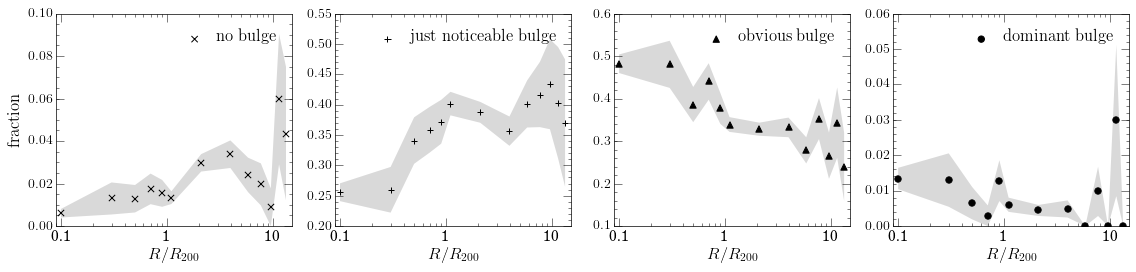

In [957]:
P.figure(figsize=(16,4))
ax = P.subplot(141)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_nb[1:], marker='x', s=40, color='k', label=r'$\rm{no}$ $\rm{bulge}$')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1enb[1:], y2enb[1:], color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{fraction}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax.legend(frameon=False)
ax = P.subplot(142)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_jnb[1:], marker='+', s=40,color='k', label=r'$\rm{just}$ $\rm{noticeable}$ $\rm{bulge}$')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1ejnb[1:], y2ejnb[1:], color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
#ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax.legend(frameon=False)
ax = P.subplot(143)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_ob[1:], marker='^', s=40,color='k',  label=r'$\rm{obvious}$ $\rm{bulge}$')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1eob[1:], y2eob[1:], color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
#ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax.legend(frameon=False)
ax = P.subplot(144)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_db[1:], marker='o', s=40,color='k',  label=r'$\rm{dominant}$ $\rm{bulge}$')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1edb[1:], y2edb[1:], color='k', alpha=0.15, edgecolor='None')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax.legend(frameon=False)
P.tight_layout()
P.savefig('bulge_fractions_over_disc_trend_with_log_radius.pdf')

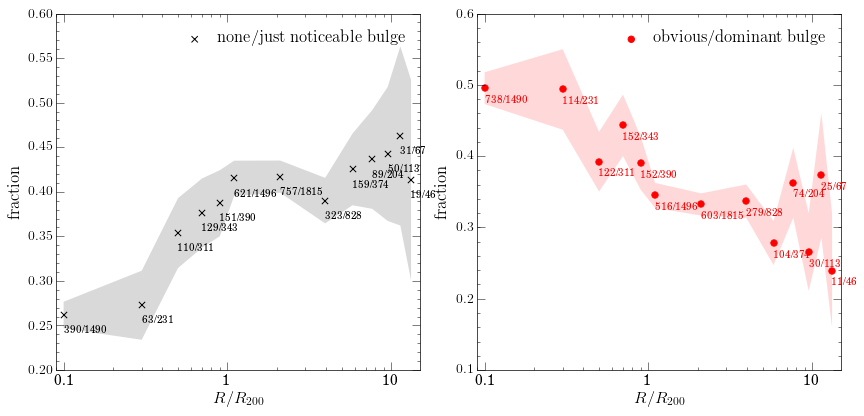

In [990]:
P.figure(figsize=(12,6))
ax = P.subplot(121)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_minb[1:], marker='x', s=40, color='k', label=r'$\rm{none}/\rm{just}$ $\rm{noticeable}$ $\rm{bulge}$')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1eminb[1:], y2eminb[1:], color='k', alpha=0.15, edgecolor='None')
for i, txt in enumerate(l_frac_minb[1:]):
    ax.annotate(txt, ((bso[1][:-1] + N.diff(bso[1])[0]/2)[i],frac_minb[1:][i]-0.02), fontsize=10)
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
#ax.set_ylim(0, 0.05)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{fraction}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax.legend(frameon=False)
ax = P.subplot(122)
ax.scatter(bso[1][:-1] + N.diff(bso[1])[0]/2, frac_maxb[1:], marker='o', s=40, color='r', label=r'$\rm{obvious}/\rm{dominant}$ $\rm{bulge}$')
ax.fill_between(bso[1][:-1] + N.diff(bso[1])[0]/2, y1emaxb[1:], y2emaxb[1:], color='r', alpha=0.15, edgecolor='None')
for i, txt in enumerate(l_frac_maxb[1:]):
    ax.annotate(txt, ((bso[1][:-1] + N.diff(bso[1])[0]/2)[i],frac_maxb[1:][i]-0.02), fontsize=10, color='r')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
#ax.set_ylim(0, 0.05)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{fraction}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([0.1, 1, 10])
ax.legend(frameon=False)
P.tight_layout()
P.savefig('min_max_bulge_fraction_trend_with_log_radius.pdf')

In [1013]:
data = Table.read('mr181920_member_long_groupID_catalog_central_satellites_with_halo_mass_projected_clustercentric_radius_vel_disp_virial_radius.fits', format='fits')
f = open('berlind_catalog_ra_dec.txt', 'a')
for n in range(len(data)):
    f.write(str(data['dr7objid'][n])+' '+str(data['RA'][n])+' '+str(data['Dec'][n])+'\n')
f.close()

In [1086]:
data= Table.read('mr181920_member_long_groupID_catalog_central_satellites_with_halo_mass_projected_clustercentric_radius_vel_disp_virial_radius_h_alpha_flux.fits', format='fits')

In [1087]:
data = data[N.where(data['number in cluster']>=2)]

In [1090]:
data = data[N.where(N.logical_and(data['h_alpha_flux']>-10000, data['h_alpha_flux']<10000))]

In [1091]:
d = cosmo.luminosity_distance(data['z']).to(u.cm)
L = Column(name ='luminosity Halpha', data = (1E-17)*data['h_alpha_flux']*4*N.pi*(d.value**2), unit=u.erg / u.s)
SFR = Column(name = 'sfr kennicutt', data=7.9E-42*((u.s*u.M_sun)/(u.erg*u.yr))*L, unit=u.M_sun/u.yr)

In [1092]:
data.add_columns([L, SFR])

In [1194]:
field = Table.read('field_candidate_sample_ivan_lt_-0.8_rv_gtr_25_gz2_gz1_extra_h_alpha.fits', format='fits')
field = field[N.where(N.logical_and(field['h_alpha_flux']>-10000, field['h_alpha_flux']<10000))]
print len(field)

47177


In [1198]:
df = cosmo.luminosity_distance(field['REDSHIFT_1']).to(u.cm)
Lf = Column(name ='luminosity Halpha', data = (1E-17)*field['h_alpha_flux']*4*N.pi*(df.value**2), unit=u.erg / u.s)
SFRf = Column(name = 'sfr kennicutt', data=7.9E-42*((u.s*u.M_sun)/(u.erg*u.yr))*Lf, unit=u.M_sun/u.yr)

In [1199]:
field.add_columns([Lf, SFRf])

In [1200]:
abs_m_gal = field['MR']
ur_gal = field['MU_MR']
print abs_m_gal
log_m_l = N.zeros(len(ur_gal))
m_msun = N.zeros_like(log_m_l)

for j in range(len(log_m_l)):
    if ur_gal[j] <=2.1:
        log_m_l[j] = -0.95 + 0.56 * ur_gal[j]
    else:
        log_m_l[j] = -0.16 + 0.18 * ur_gal[j]
    m_msun[j] = (((4.62 - abs_m_gal[j])/2.5) + log_m_l[j])

sm = Column(name='stellar mass', data=m_msun, unit=u.M_sun)

   MR   
--------
-21.6765
-20.3264
-16.6468
-21.8703
-21.5725
-21.7165
-18.8715
-22.8834
-22.8896
-22.5648
     ...
-22.0743
-20.9069
-21.1014
-21.9566
-21.9808
-21.6321
-21.6849
-22.2907
-22.3069
-21.6014
-20.8063
Length = 47177 rows


In [1202]:
from scipy.interpolate import interp1d
def halo_func(Mh, c, M0, a, b, d):
    return c*Mh*((((Mh/M0)**(-a)) + ((Mh/M0)**(b)))**(-d))

Mh_t =N.linspace(10, 18, 500)
Ms_t = halo_func(10**Mh_t, 0.129, (10**(11.4)), 0.926, 0.261, 2.440)
halomassfunc = interp1d(N.log10(Ms_t), Mh_t, kind='linear')

In [1203]:
hm = Column(name='halo mass', data=halomassfunc(sm), unit=u.M_sun)

In [1204]:
field.add_columns([sm, hm])

In [1213]:
field.write('field_candidate_sample_ivan_lt_-0.8_rv_gtr_25_gz2_gz1_extra_h_alpha_sfr_halo_stellar_masses.fits', format='fits')

In [1214]:
cent = data[N.where(data['central or satellite']==1)]

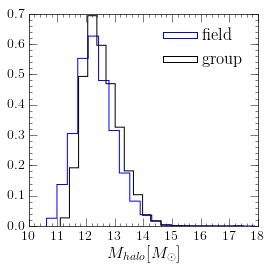

In [1235]:
P.figure(figsize=(4,4))
P.hist(field['halo mass'], histtype='step', color='b', bins=20, normed=True, label=r'$\rm{field}$')
P.hist(cent['halo mass'], histtype='step', color='k', bins=20, normed=True, label=r'$\rm{group}$')
P.minorticks_on()
P.xlabel(r'$M_{halo} [M_{\odot}]$')
P.legend()
P.savefig('group_field_full_halo_mass_comparison.png')

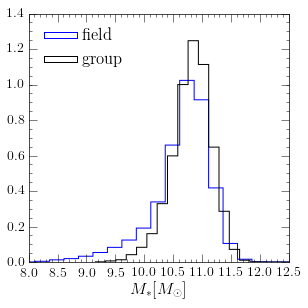

In [1241]:
P.figure(figsize=(4.5,4.5))
P.hist(field['stellar mass'], histtype='step', color='b', bins=20, normed=True, label=r'$\rm{field}$')
P.hist(cent['stellar mass'], histtype='step', color='k', bins=20, normed=True, label=r'$\rm{group}$')
P.minorticks_on()
P.xlim(8, 12.5)
P.xlabel(r'$M_{*} [M_{\odot}]$')
P.legend(loc=2)
P.savefig('group_field_full_stellar_mass_comparison.png')

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


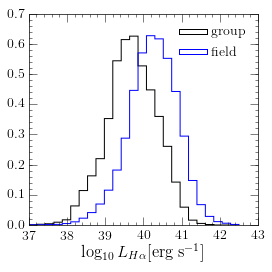

In [1242]:
P.figure(figsize=(4,4))
P.hist(N.log10(data['luminosity Halpha']), bins=25, histtype='step',  range=(37, 42.5), normed=True, color='k', label=r'$\rm{group}$')
P.hist(N.log10(field['luminosity Halpha']), bins=25, histtype='step',  range=(37, 42.5), normed=True, color='b', label=r'$\rm{field}$')
P.minorticks_on()
P.xlabel(r'$\log_{10}L_{H\alpha}[\rm{erg}$ $\rm{s}^{-1}]$')
P.legend(fontsize=14)
P.savefig('group_field_full_L_h_alpha_comparison.png')

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


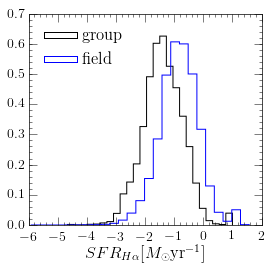

In [1244]:
P.figure(figsize=(4,4))
P.hist(N.log10(data['sfr kennicutt']), bins=25, histtype='step', normed=True, color='k', label=r'$\rm{group}$')
P.hist(N.log10(field['sfr kennicutt']), bins=25, histtype='step', normed=True, color='b', label=r'$\rm{field}$')
P.minorticks_on()
P.xlabel(r'$SFR_{H\alpha} [M_{\odot}\rm{yr}^{-1}]$')
P.legend(loc=2)
P.savefig('group_field_full_SFR_h_alpha_comparison.png')

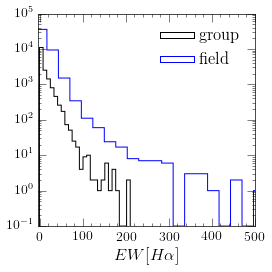

In [1234]:
P.figure(figsize=(4,4))
P.hist(data['h_alpha_eqw']*-1, bins=25, histtype='step', log=True, color='k', label=r'$\rm{group}$')
P.hist(field['h_alpha_eqw']*-1, bins=25, histtype='step', log=True, color='b', label=r'$\rm{field}$')
P.xlim(-5, 500)
P.minorticks_on()
P.legend()
P.xlabel(r'$EW[H\alpha]$')
#P.ylim(1, 10000)
P.savefig('group_field_full_eqw_h_alpha_comparison.png')

In [1247]:
fieldsfr = N.percentile(field['sfr kennicutt'], [25, 50, 75])

In [1159]:
binss = N.array([0, 0.6, 0.9, 1.5, 2.1, 3.3, 5.0, 7.5, 10.0, 12.5, 15.0])

In [1164]:
sat = data[N.where(data['central or satellite']==0)]

In [1165]:
bssfr25 = b_s((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'], sat['sfr kennicutt'], statistic=lambda y: N.percentile(y, 25), bins=binss, range=(0,15))
bssfr50 = b_s((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'], sat['sfr kennicutt'], statistic=lambda y: N.percentile(y, 50), bins=binss, range=(0,15))
bssfr75 = b_s((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'], sat['sfr kennicutt'], statistic=lambda y: N.percentile(y, 75), bins=binss, range=(0,15))

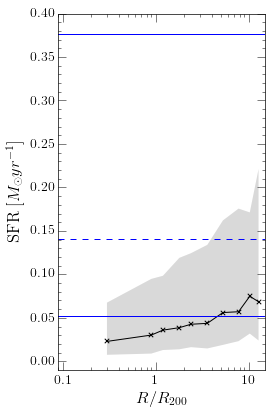

In [1249]:
P.figure(figsize=(4,6))
ax = P.subplot(111)
ax.scatter(bssfr50[1][:-1] + N.diff(bssfr50[1])[0]/2, bssfr50[0], marker='x', color='k')
ax.plot(bssfr50[1][:-1] + N.diff(bssfr50[1])[0]/2, bssfr50[0], color='k', lw=1)
ax.fill_between(bssfr50[1][:-1] + N.diff(bssfr50[1])[0]/2, bssfr25[0], bssfr75[0], color='k', alpha=0.15, edgecolor='None')
ax.axhline(fieldsfr[0], color='b')
ax.axhline(fieldsfr[1], color='b', linestyle='dashed')
ax.axhline(fieldsfr[2], color='b')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
#ax.set_ylim(0, 0.05)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{SFR}$ $[M_{\odot}yr^{-1}]$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([r'$0.1$', r'$1$', r'$10$'])
ax.set_ylim(-0.01)
P.tight_layout()
P.savefig('sfr_trend_with_log_radius_field_blue_hlines_gomez_03.pdf')

In [1301]:
bsha25 = b_s((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'], sat['h_alpha_eqw']*-1, statistic=lambda y: N.percentile(y, 25), bins=binss, range=(0,15))
bsha50 = b_s((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'], sat['h_alpha_eqw']*-1, statistic=lambda y: N.percentile(y, 50), bins=binss, range=(0,15))
bsha75 = b_s((sat['projected cluster centric radius'].to(u.Mpc))/sat['virial radius'], sat['h_alpha_eqw']*-1, statistic=lambda y: N.percentile(y, 75), bins=binss, range=(0,15))
fieldha = N.percentile(field['h_alpha_eqw']*-1, [25, 50, 75])

In [1302]:
bsha25

(array([ 0.4353 ,  0.55153,  0.78815,  0.92379,  0.97099,  0.97615,
         1.23854,  1.45782,  2.20291,  1.14169]),
 array([  0. ,   0.6,   0.9,   1.5,   2.1,   3.3,   5. ,   7.5,  10. ,
         12.5,  15. ]),
 array([ 3,  5,  7, ...,  4, 11,  6]))

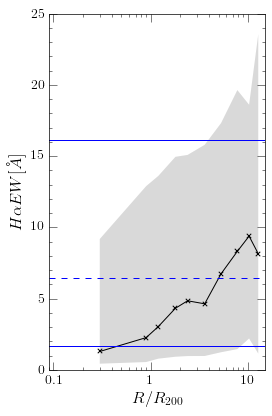

In [1314]:
P.figure(figsize=(4,6))
ax = P.subplot(111)
ax.scatter(bsha50[1][:-1] + N.diff(bsha50[1])[0]/2, bsha50[0], marker='x', color='k')
ax.plot(bsha50[1][:-1] + N.diff(bsha50[1])[0]/2, bsha50[0], color='k', lw=1)
ax.fill_between(bsha50[1][:-1] + N.diff(bsha50[1])[0]/2, bsha25[0], bsha75[0], color='k', alpha=0.15, edgecolor='None')
ax.axhline(fieldha[0], color='b')
ax.axhline(fieldha[1], color='b', linestyle='dashed')
ax.axhline(fieldha[2], color='b')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(-1, 25)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$H\alpha EW [\AA]$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([r'$0.1$', r'$1$', r'$10$'])
ax.set_ylim(-0.01)
P.tight_layout()
P.savefig('h_alpha_eqw_trend_with_log_radius_field_blue_hlines_gomez_03.pdf')

In [1250]:
discs = data[N.where(data['t01_smooth_or_features_a02_features_or_disk_debiased']>0.8)]
smooth = data[N.where(data['t01_smooth_or_features_a01_smooth_debiased']>0.8)]
fielddiscs = field[N.where(field['t01_smooth_or_features_a02_features_or_disk_debiased']>0.8)]
fieldsmooth = field[N.where(field['t01_smooth_or_features_a01_smooth_debiased']>0.8)]

In [1251]:
fielddsfr = N.percentile(fielddiscs['sfr kennicutt'], [25, 50, 75])
fieldssfr = N.percentile(fieldsmooth['sfr kennicutt'], [25, 50, 75])

In [1191]:
bssfr25d = b_s((discs['projected cluster centric radius'].to(u.Mpc))/discs['virial radius'], discs['sfr kennicutt'], statistic=lambda y: N.percentile(y, 25), bins=binss, range=(0,15))
bssfr50d = b_s((discs['projected cluster centric radius'].to(u.Mpc))/discs['virial radius'], discs['sfr kennicutt'], statistic=lambda y: N.percentile(y, 50), bins=binss, range=(0,15))
bssfr75d = b_s((discs['projected cluster centric radius'].to(u.Mpc))/discs['virial radius'], discs['sfr kennicutt'], statistic=lambda y: N.percentile(y, 75), bins=binss, range=(0,15))

In [1192]:
bssfr25s = b_s((smooth['projected cluster centric radius'].to(u.Mpc))/smooth['virial radius'], smooth['sfr kennicutt'], statistic=lambda y: N.percentile(y, 25), bins=binss, range=(0,15))
bssfr50s = b_s((smooth['projected cluster centric radius'].to(u.Mpc))/smooth['virial radius'], smooth['sfr kennicutt'], statistic=lambda y: N.percentile(y, 50), bins=binss, range=(0,15))
bssfr75s = b_s((smooth['projected cluster centric radius'].to(u.Mpc))/smooth['virial radius'], smooth['sfr kennicutt'], statistic=lambda y: N.percentile(y, 75), bins=binss, range=(0,15))

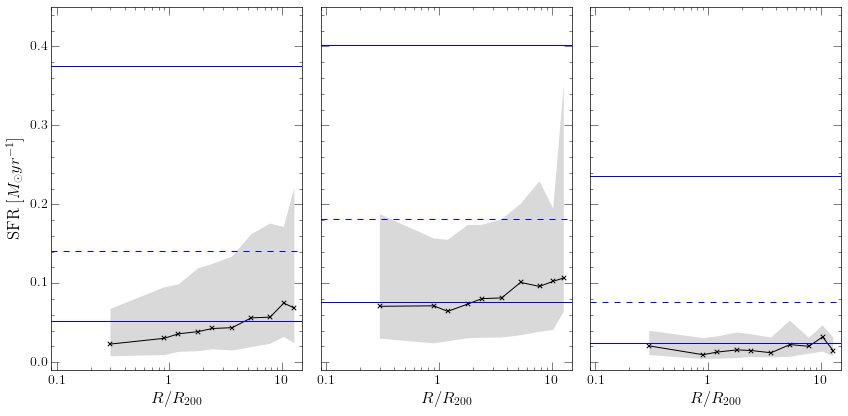

In [1254]:
P.figure(figsize=(12,6))
ax = P.subplot(131)
ax.scatter(bssfr50[1][:-1] + N.diff(bssfr50[1])[0]/2, bssfr50[0], marker='x', color='k')
ax.plot(bssfr50[1][:-1] + N.diff(bssfr50[1])[0]/2, bssfr50[0], color='k', lw=1)
ax.fill_between(bssfr50[1][:-1] + N.diff(bssfr50[1])[0]/2, bssfr25[0], bssfr75[0], color='k', alpha=0.15, edgecolor='None')
ax.axhline(fieldsfr[0], color='b')
ax.axhline(fieldsfr[1], color='b', linestyle='dashed')
ax.axhline(fieldsfr[2], color='b')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(0, 0.45)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_ylabel(r'$\rm{SFR}$ $[M_{\odot}yr^{-1}]$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([r'$0.1$', r'$1$', r'$10$'])
ax.set_ylim(-0.01)
ax = P.subplot(132)
ax.scatter(bssfr50d[1][:-1] + N.diff(bssfr50d[1])[0]/2, bssfr50d[0], marker='x', color='k')
ax.plot(bssfr50d[1][:-1] + N.diff(bssfr50d[1])[0]/2, bssfr50d[0], color='k', lw=1)
ax.fill_between(bssfr50d[1][:-1] + N.diff(bssfr50d[1])[0]/2, bssfr25d[0], bssfr75d[0], color='k', alpha=0.15, edgecolor='None')
ax.axhline(fielddsfr[0], color='b')
ax.axhline(fielddsfr[1], color='b', linestyle='dashed')
ax.axhline(fielddsfr[2], color='b')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
#ax.set_ylim(0, 0.05)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([r'$0.1$', r'$1$', r'$10$'])
ax.set_ylim(-0.01, 0.45)
ax.tick_params('y', labelleft='off')
ax = P.subplot(133)
ax.scatter(bssfr50s[1][:-1] + N.diff(bssfr50s[1])[0]/2, bssfr50s[0], marker='x', color='k')
ax.plot(bssfr50s[1][:-1] + N.diff(bssfr50s[1])[0]/2, bssfr50s[0], color='k', lw=1)
ax.fill_between(bssfr50s[1][:-1] + N.diff(bssfr50s[1])[0]/2, bssfr25s[0], bssfr75s[0], color='k', alpha=0.15, edgecolor='None')
ax.axhline(fieldssfr[0], color='b')
ax.axhline(fieldssfr[1], color='b', linestyle='dashed')
ax.axhline(fieldssfr[2], color='b')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(-0.01, 0.45)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([r'$0.1$', r'$1$', r'$10$'])
ax.tick_params('y', labelleft='off')
P.tight_layout()
P.subplots_adjust(wspace=0.0, hspace=0.0)
P.savefig('sfr_trend_with_log_radius_disc_smooth_field_blue_hlines_gomez_03.pdf')

In [1306]:
bshad25 = b_s((discs['projected cluster centric radius'].to(u.Mpc))/discs['virial radius'], discs['h_alpha_eqw']*-1, statistic=lambda y: N.percentile(y, 25), bins=binss, range=(0,15))
bshad50 = b_s((discs['projected cluster centric radius'].to(u.Mpc))/discs['virial radius'], discs['h_alpha_eqw']*-1, statistic=lambda y: N.percentile(y, 50), bins=binss, range=(0,15))
bshad75 = b_s((discs['projected cluster centric radius'].to(u.Mpc))/discs['virial radius'], discs['h_alpha_eqw']*-1, statistic=lambda y: N.percentile(y, 75), bins=binss, range=(0,15))
fieldhad = N.percentile(fielddiscs['h_alpha_eqw']*-1, [25, 50, 75])

In [1307]:
bshas25 = b_s((smooth['projected cluster centric radius'].to(u.Mpc))/smooth['virial radius'], smooth['h_alpha_eqw']*-1, statistic=lambda y: N.percentile(y, 25), bins=binss, range=(0,15))
bshas50 = b_s((smooth['projected cluster centric radius'].to(u.Mpc))/smooth['virial radius'], smooth['h_alpha_eqw']*-1, statistic=lambda y: N.percentile(y, 50), bins=binss, range=(0,15))
bshas75 = b_s((smooth['projected cluster centric radius'].to(u.Mpc))/smooth['virial radius'], smooth['h_alpha_eqw']*-1, statistic=lambda y: N.percentile(y, 75), bins=binss, range=(0,15))
fieldhas = N.percentile(fieldsmooth['h_alpha_eqw']*-1, [25, 50, 75])

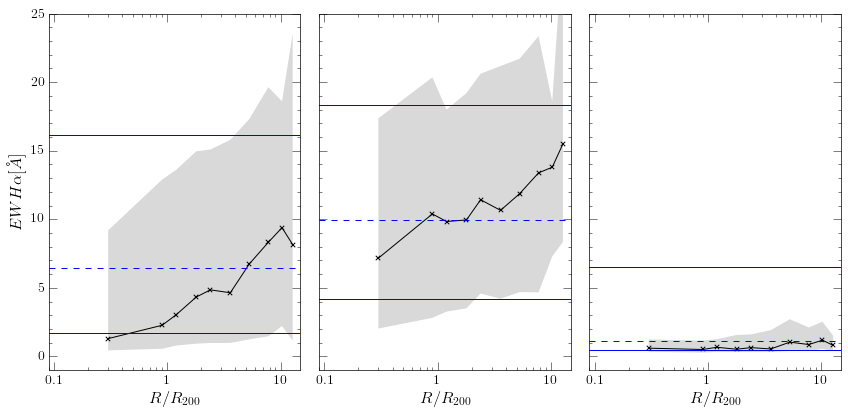

In [1320]:
P.figure(figsize=(12,6))
ax = P.subplot(131)
ax.scatter(bssfr50[1][:-1] + N.diff(bssfr50[1])[0]/2, bsha50[0], marker='x', color='k')
ax.plot(bssfr50[1][:-1] + N.diff(bssfr50[1])[0]/2, bsha50[0], color='k', lw=1)
ax.fill_between(bssfr50[1][:-1] + N.diff(bssfr50[1])[0]/2, bsha25[0], bsha75[0], color='k', alpha=0.15, edgecolor='None')
ax.axhline(fieldha[0], color='b')
ax.axhline(fieldha[1], color='b', linestyle='dashed')
ax.axhline(fieldha[2], color='b')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(-1, 25)
ax.set_ylabel(r'$EW H\alpha [\AA]$')
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([r'$0.1$', r'$1$', r'$10$'])
#ax.set_ylim(-0.01)
ax = P.subplot(132)
ax.scatter(bssfr50d[1][:-1] + N.diff(bssfr50d[1])[0]/2, bshad50[0], marker='x', color='k')
ax.plot(bssfr50d[1][:-1] + N.diff(bssfr50d[1])[0]/2, bshad50[0], color='k', lw=1)
ax.fill_between(bssfr50d[1][:-1] + N.diff(bssfr50d[1])[0]/2, bshad25[0], bshad75[0], color='k', alpha=0.15, edgecolor='None')
ax.axhline(fieldhad[0], color='b')
ax.axhline(fieldhad[1], color='b', linestyle='dashed')
ax.axhline(fieldhad[2], color='b')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(-1, 25)
ax.set_xlabel(r'$R/R_{200}$')
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([r'$0.1$', r'$1$', r'$10$'])
ax.tick_params('y', labelleft='off')
ax = P.subplot(133)
ax.scatter(bssfr50s[1][:-1] + N.diff(bssfr50s[1])[0]/2, bshas50[0], marker='x', color='k')
ax.plot(bssfr50s[1][:-1] + N.diff(bssfr50s[1])[0]/2, bshas50[0], color='k', lw=1)
ax.fill_between(bssfr50s[1][:-1] + N.diff(bssfr50s[1])[0]/2, bshas25[0], bshas75[0], color='k', alpha=0.15, edgecolor='None')
ax.axhline(fieldhas[0], color='b')
ax.axhline(fieldhas[1], color='b', linestyle='dashed')
ax.axhline(fieldhas[2], color='b')
ax.set_xscale('log')
ax.minorticks_on()
ax.set_xlim(0.09, 15)
ax.set_ylim(-1, 25)
ax.set_xticks([0.1, 1, 10])
ax.set_xticklabels([r'$0.1$', r'$1$', r'$10$'])
ax.set_xlabel(r'$R/R_{200}$')
ax.tick_params('y', labelleft='off')
P.tight_layout()
P.subplots_adjust(wspace=0.0, hspace=0.0)
P.savefig('h_alpha_eqw_trend_with_log_radius_disc_smooth_field_blue_hlines_gomez_03.pdf')

In [1261]:
from scipy.stats import ks_2samp

In [1285]:
logbins = [  0.     ,   0.2    ,   0.4    ,   0.6    ,   0.8    ,   1.     ,
         2.     ,   3.85714,   5.71429,   7.57143,   9.42857,  11.28571,
        13.14286,  15.     , 17., 19., 21., 25., 30.]

In [1286]:
idsfr = N.digitize((data['projected cluster centric radius'].to(u.Mpc))/data['virial radius'], logbins)
for n in range(len(logbins)):
    dsfr = data['sfr kennicutt'][idsfr==n]
    D, p = ks_2samp(field['sfr kennicutt'], dsfr)
    print n, len(dsfr), D, p*100

0 0 nan nan
1 4526 0.395773933633 0.0
2 551 0.462881898178 7.17096118106e-101
3 653 0.431511727965 1.28189003169e-103
4 689 0.398033739658 9.09051933696e-93
5 729 0.37393945278 1.98507295072e-86
6 2956 0.344581570748 1.21694834075e-286
7 3384 0.309606994854 1.8387415639e-262
8 1561 0.28156986236 3.89035390362e-103
9 688 0.23733563877 6.40391711039e-32
10 319 0.238664927778 2.51919464648e-14
11 195 0.213544735782 2.93269632134e-06
12 106 0.228678549389 0.00236714971368
13 84 0.203697170837 0.15534342204
14 53 0.226121939016 0.727282499607
15 55 0.257342657343 0.105913394768
16 35 0.213983811724 6.98335640931
17 43 0.101435908609 74.6287010057
18 36 0.29661699557 0.265298231776


In [1322]:
idsfr = N.digitize((smooth['projected cluster centric radius'].to(u.Mpc))/smooth['virial radius'], logbins)
for n in range(len(logbins)):
    dsfr = smooth['h_alpha_eqw'][idsfr==n]*-1
    D, p = ks_2samp(fieldsmooth['h_alpha_eqw']*-1, dsfr)
    print n, len(dsfr), D, p*100

0 0 nan nan
1 1281 0.270943682858 4.52297042074e-60
2 121 0.320099078286 4.08018520533e-09
3 125 0.305632695834 1.76673188553e-08
4 113 0.290792704274 1.09129474581e-06
5 97 0.308956945191 1.75713885804e-06
6 438 0.212352692772 5.19864599798e-14
7 500 0.192019910925 9.40545318318e-13
8 223 0.122130050717 0.333578504331
9 95 0.12943755774 8.22270774879
10 48 0.224352676622 1.39919591694
11 24 0.187647367042 33.5970834243
12 14 0.311856731165 10.6281188939
13 14 0.244283094427 32.8886231648
14 6 0.25596017815 76.2508526309
15 11 0.367042179722 7.87087442618
16 4 0.395205658894 45.149604026
17 5 0.397851716007 31.9730225146
18 7 0.301845128934 47.0409904542


In [1323]:
logbins[9:]

[7.57143, 9.42857, 11.28571, 13.14286, 15.0, 17.0, 19.0, 21.0, 25.0, 30.0]

In [1327]:
Hc, Xc, Yc = N.histogram2d(cent['MU_MR'], cent['NUV_U'], bins=30, range=((0,4),(-0.5,5)))#, weights=centh['t01_smooth_or_features_a02_features_or_disk_debiased'])
Hs, Xs, Ys = N.histogram2d(sat['MU_MR'], sat['NUV_U'], bins=30, range=((0,4),(-0.5,5)))#, weights=centm['t01_smooth_or_features_a02_features_or_disk_debiased'])
Hf, Xf, Yf = N.histogram2d(field['MU_MR'], field['NUV_U'], bins=30, range=((0,4),(-0.5,5)))#, weights=centl['t01_smooth_or_features_a02_features_or_disk_debiased'])


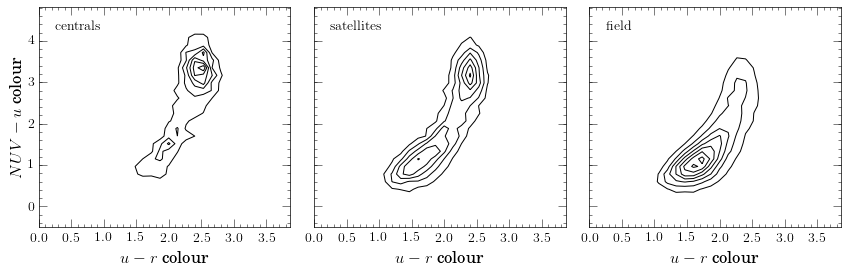

In [1331]:
P.figure(figsize=(12,4))
ax1 = P.subplot(131)
ax1.contour(Xc[:-1], Yc[:-1], Hc.T, origin='lower', colors='k', label=r'$\rm{centrals}$')
ax2 = P.subplot(132)
ax2.contour(Xs[:-1], Ys[:-1], Hs.T, origin='lower', colors='k', label=r'$\rm{satellites}$')
ax2.tick_params('y', labelleft='off')
ax3 = P.subplot(133)
ax3.contour(Xf[:-1], Yf[:-1], Hf.T, origin='lower', colors='k', label=r'$\rm{field}$')
ax3.tick_params('y', labelleft='off')
ax1.set_xlabel(r'$u-r$ \rm{colour}')
ax2.set_xlabel(r'$u-r$ \rm{colour}')
ax3.set_xlabel(r'$u-r$ \rm{colour}')
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
ax1.text(0.25, 4.25, r'$\rm{centrals}$')
ax2.text(0.25, 4.25, r'$\rm{satellites}$')
ax3.text(0.25, 4.25, r'$\rm{field}$')
ax1.set_ylabel(r'$NUV-u$ \rm{colour}')
# labels = ax4.get_xticklabels() 
# for label in labels: 
#     label.set_rotation(45) 
# labels = ax5.get_xticklabels() 
# for label in labels: 
#     label.set_rotation(45) 
# labels = ax6.get_xticklabels() 
# for label in labels: 
#     label.set_rotation(45) 
P.subplots_adjust(wspace=0.0, hspace=0.0)
P.tight_layout()
P.savefig('colour_colour_cent_sat_field.pdf')

In [1334]:
Hc, Xc, Yc = N.histogram2d(cent['MU_MR'], cent['NUV_U'], bins=30, range=((0,4),(-0.5,5)), weights=cent['t01_smooth_or_features_a02_features_or_disk_debiased'])
Hs, Xs, Ys = N.histogram2d(sat['MU_MR'], sat['NUV_U'], bins=30, range=((0,4),(-0.5,5)), weights=sat['t01_smooth_or_features_a02_features_or_disk_debiased'])
Hf, Xf, Yf = N.histogram2d(field['MU_MR'], field['NUV_U'], bins=30, range=((0,4),(-0.5,5)), weights=field['t01_smooth_or_features_a02_features_or_disk_debiased'])


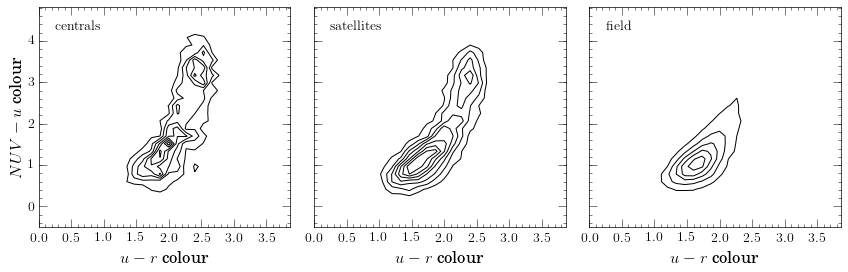

In [1335]:
P.figure(figsize=(12,4))
ax1 = P.subplot(131)
ax1.contour(Xc[:-1], Yc[:-1], Hc.T, origin='lower', colors='k', label=r'$\rm{centrals}$')
ax2 = P.subplot(132)
ax2.contour(Xs[:-1], Ys[:-1], Hs.T, origin='lower', colors='k', label=r'$\rm{satellites}$')
ax2.tick_params('y', labelleft='off')
ax3 = P.subplot(133)
ax3.contour(Xf[:-1], Yf[:-1], Hf.T, origin='lower', colors='k', label=r'$\rm{field}$')
ax3.tick_params('y', labelleft='off')
ax1.set_xlabel(r'$u-r$ \rm{colour}')
ax2.set_xlabel(r'$u-r$ \rm{colour}')
ax3.set_xlabel(r'$u-r$ \rm{colour}')
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
ax1.text(0.25, 4.25, r'$\rm{centrals}$')
ax2.text(0.25, 4.25, r'$\rm{satellites}$')
ax3.text(0.25, 4.25, r'$\rm{field}$')
ax1.set_ylabel(r'$NUV-u$ \rm{colour}')
# labels = ax4.get_xticklabels() 
# for label in labels: 
#     label.set_rotation(45) 
# labels = ax5.get_xticklabels() 
# for label in labels: 
#     label.set_rotation(45) 
# labels = ax6.get_xticklabels() 
# for label in labels: 
#     label.set_rotation(45) 
P.subplots_adjust(wspace=0.0, hspace=0.0)
P.tight_layout()
P.savefig('colour_colour_cent_sat_field_disk_debiased_weighted.pdf')

In [1336]:
Hc, Xc, Yc = N.histogram2d(cent['MU_MR'], cent['NUV_U'], bins=30, range=((0,4),(-0.5,5)), weights=cent['t01_smooth_or_features_a01_smooth_debiased'])
Hs, Xs, Ys = N.histogram2d(sat['MU_MR'], sat['NUV_U'], bins=30, range=((0,4),(-0.5,5)), weights=sat['t01_smooth_or_features_a01_smooth_debiased'])
Hf, Xf, Yf = N.histogram2d(field['MU_MR'], field['NUV_U'], bins=30, range=((0,4),(-0.5,5)), weights=field['t01_smooth_or_features_a01_smooth_debiased'])


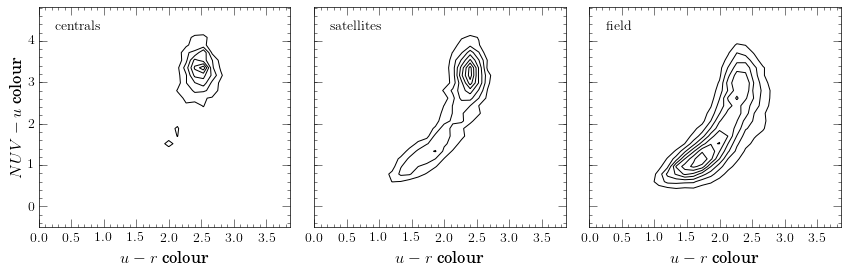

In [1337]:
P.figure(figsize=(12,4))
ax1 = P.subplot(131)
ax1.contour(Xc[:-1], Yc[:-1], Hc.T, origin='lower', colors='k', label=r'$\rm{centrals}$')
ax2 = P.subplot(132)
ax2.contour(Xs[:-1], Ys[:-1], Hs.T, origin='lower', colors='k', label=r'$\rm{satellites}$')
ax2.tick_params('y', labelleft='off')
ax3 = P.subplot(133)
ax3.contour(Xf[:-1], Yf[:-1], Hf.T, origin='lower', colors='k', label=r'$\rm{field}$')
ax3.tick_params('y', labelleft='off')
ax1.set_xlabel(r'$u-r$ \rm{colour}')
ax2.set_xlabel(r'$u-r$ \rm{colour}')
ax3.set_xlabel(r'$u-r$ \rm{colour}')
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
ax1.text(0.25, 4.25, r'$\rm{centrals}$')
ax2.text(0.25, 4.25, r'$\rm{satellites}$')
ax3.text(0.25, 4.25, r'$\rm{field}$')
ax1.set_ylabel(r'$NUV-u$ \rm{colour}')
# labels = ax4.get_xticklabels() 
# for label in labels: 
#     label.set_rotation(45) 
# labels = ax5.get_xticklabels() 
# for label in labels: 
#     label.set_rotation(45) 
# labels = ax6.get_xticklabels() 
# for label in labels: 
#     label.set_rotation(45) 
P.subplots_adjust(wspace=0.0, hspace=0.0)
P.tight_layout()
P.savefig('colour_colour_cent_sat_field_smooth_debiased_weighted.pdf')